In [1]:
import sys
import warnings
sys.path.append('../')
warnings.filterwarnings('ignore')

%matplotlib widget
%load_ext autoreload
%autoreload 1
%aimport utils, GroupingAlgorithm, HEEM_VQE_Functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.auto import tqdm
from os.path import isfile, exists
from os import mkdir

from qiskit import IBMQ, Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.ignis.verification import get_ghz_simple
from qiskit.compiler import transpile
from qiskit.tools.monitor import job_monitor
from qiskit.opflow.state_fns import CircuitStateFn
from qiskit.providers.aer.extensions.snapshot_statevector import *
from qiskit.test.mock import FakeMontreal

from utils import get_backend_connectivity, molecules, Label2Chain, from_string_to_numbers, load_grouping_data, current_time, load_data_IBMQ, send_ibmq_parallel
from GroupingAlgorithm import groupingWithOrder, TPBgrouping
from HEEM_VQE_Functions import measure_circuit_factor, probability2expected_binary, post_process_results, probability2expected_parallel, post_process_results_2, post_process_results_3

In [67]:
NUM_SHOTS = 2 ** 14
# NUM_SHOTS = 2 ** 16

def compute_energy_sparse(Groups, Measurements, method, n_chunks=10, layout=None, return_energy_temp=False, noisy=True, shots=NUM_SHOTS):
    
    circuits = [measure_circuit_factor(measurement, n_qubits, measure_all=False).compose(state_0, front=True) for measurement
                 in Measurements]
    
    if noisy:
        kwards_run = {'coupling_map': coupling_map, 'noise_model': noise_model, 'basis_gates': basis_gates}
    else:
        kwards_run = {}
    
    if shots == -1:
        shots = 20000 * len(Groups)  # Max allowed shots
    
    kwards_run['shots'] = shots // len(Groups)
                
    if layout is not None:
        kwards_run['initial_layout'] = layout[::-1]
    
    jobs = send_ibmq_parallel(backed_calculations, n_chunks, circuits, job_tag=[molecule_name, method], verbose=False,
                              progress_bar=True, kwards_run=kwards_run)

    counts = []
    
    for job in jobs:
        counts += job.result().get_counts()
    
    energy_temp = []
    pbar = tqdm(range(len(counts)), desc='Computing energy')
    for j in pbar:
        counts_indices, counts_values = post_process_results_3(counts[j])

        diagonals, factors = probability2expected_binary(coeffs, labels, [Groups[j]], [Measurements[j]], shift=False)
        diagonals = [(~diagonal * 2 - 1).astype('int8') for diagonal in diagonals[0][:, counts_indices]]

        energy_temp.append(np.sum((diagonals * np.array(factors[0])[:, None]) * counts_values[None, :]) / kwards_run['shots'])

    returns = [jobs, sum(energy_temp)]
    
    if return_energy_temp:
        returns.append(energy_temp)
        
    return returns

In [59]:
# 1: Luciano, 2: Guillermo, 3: Gabriel, 4: Fran, 5: David
index = None
if index is None:
    raise Exception('Use you index!')
    
    
def check_folder_create(path):
    if exists(path):
        pass
    else:
        mkdir(path)

def save_data(energy, method):
    subdics = ['data', 'energies', initial_state, 'partial']
    
    folder = '../'
    for dic in subdics:
        folder += dic + '/'
        check_folder_create(folder)
    
    file = folder + molecule_name + '_' + method +'_' + str(index) + '.npy'
    if isfile(file):
        data = np.load(file)
    else:
        data = np.array([])
    
    data = np.append(data, energy)
    np.save(file, data)

In [60]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    IBMQ.load_account()

provider_main = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# provider_CSIC = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic')

# name_backend = 'ibmq_montreal'
# backend = provider_CSIC.get_backend(name_backend)
backend = FakeMontreal()
WC_device = get_backend_connectivity(backend)

G_device = nx.Graph()
G_device.add_edges_from(WC_device)

ibmqfactory.load_account:WARNING:1970-03-18 09:48:23,011: Credentials are already in use. The existing account in the session will be replaced.


In [61]:
backend_hpc = provider_main.get_backend('ibmq_qasm_simulator')
backed_simulation = provider_main.get_backend('simulator_statevector')
simulator = Aer.get_backend('aer_simulator')  # Backend for simulation

device = QasmSimulator.from_backend(backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
# noise_model = None
basis_gates = noise_model.basis_gates if noise_model is not None else None

backed_calculations = backend_hpc

In [62]:
shots_TPB = {'H2': 300, 'LiH': 300, 'BeH2': 300, 'H2O': 300, 'CH4': 300,
             'C2H2': 300, 'CH3OH': 300, 'C2H6': 100}

shots_EM = {'H2': 300, 'LiH': 300, 'BeH2': 300, 'H2O': 300, 'CH4': 300,
            'C2H2': 100, 'CH3OH': 50, 'C2H6': 25}

shots_HEEM = {'H2': 300, 'LiH': 300, 'BeH2': 300, 'H2O': 300, 'CH4': 300,
              'C2H2': 300, 'CH3OH': 300, 'C2H6': 50}

In [63]:
# All molecules H2, LiH, H2O, CH4, C2H2, CH3OH, C2H6
molecule_name = 'H2'
initial_state = '0xN'

try:
    qubit_op = molecules(molecule_name)
    paulis, coeffs, labels = Label2Chain(qubit_op)
except AttributeError:
    paulis, coeffs, labels = np.load('../data/molecules_qubitop_list.npy', allow_pickle=True).item()[molecule_name]

n_qubits = len(paulis[0])
state_0 = QuantumCircuit(n_qubits)
# state_0 = state_0.compose(get_ghz_simple(n_qubits, measure=False))  # Initialized in the GHZ state

print(f'{len(paulis)} total Pauli strings')
print(f'{n_qubits} qubits')

Molecule loaded
5 total Pauli strings
2 qubits


# Exact energy

## $|0\rangle^{\otimes N}$

In [64]:
if initial_state == '0xN':
    energy_exact = 0

    for i in range(len(labels)):
        label = labels[i]
        if 'X' not in label and 'Y' not in label:
            energy_exact += coeffs[i]
    print('Exact energy: {}'.format(energy_exact))

Exact energy: -1.0685130305334074


## $|\mathrm{GHZ}\rangle$

In [10]:
if initial_state == 'GHZ':
    diagonals = {'I': np.array([1, 0, 0, 1]), 'X': np.array([0, 1, 1, 0]),
                 'Y': np.array([0, 1j, -1j, 0]), 'Z': np.array([1, 0, 0, -1])}

    energy_exact = 0
    for label, coeff in zip(labels, coeffs):
        diagonal = np.ones(4, dtype=complex)
        for op in label:
            diagonal *= diagonals[op]
        energy_exact += coeff * np.sum(diagonal) / 2

    print('Exact energy: {}'.format(energy_exact.real))

## Exact (Numerical)

psi = CircuitStateFn(state_0)
energy_exact = psi.adjoint().compose(qubit_op).compose(psi).eval().real
    
print('Exact energy: {}'.format(energy_exact))

## Exact (Simulation)

In [32]:
Groups, Measurements, _ = load_grouping_data(molecule_name, 'EM')
# Groups, Measurements, _ = groupingWithOrder(paulis, connected=True, print_progress=True)
print('Number of groups: {}'.format(len(Groups)))

circuits_exact = []
for j, measure in enumerate(Measurements):
    circuit = measure_circuit_factor(measure, n_qubits, make_measurements=False)
    circuit = circuit.compose(state_0, front=True)
    # circuit.save_statevector()
    circuit.snapshot_statevector('snapshot')
    circuits_exact.append(circuit)

Number of groups: 205


In [35]:
n_max = 100

if n_max == -1:
    n_max = len(circuits_exact)
n_runs = int(np.ceil(len(circuits_exact) / n_max))
print(n_runs)

3


In [40]:
jobs = send_ibmq_parallel(backed_calculations, n_max, circuits_exact, job_tag=molecule_name, kwards_run={'shots': 1}, progress_bar=True, verbose=False)
jobs_ids = [job.job_id() for job in jobs]

np.save(molecule_name + '_exact_job_ids.npy', jobs_ids)

Jobs completed:   0%|          | 0/3 [00:00<?, ?it/s]

In [37]:
jobs_ids = np.load(molecule_name + '_exact_job_ids.npy').tolist()

In [39]:
energy_exact = 0

pbar = tqdm(total=len(jobs_ids), desc='Computing exact energy')
for i in range(len(jobs_ids)):
    prob = load_data_IBMQ(jobs_ids[i], verbose=True)
    
    initial = i * n_max
    final = min(initial + n_max, len(circuits_exact))
    
    temp = probability2expected_parallel(-1, coeffs, labels, Groups[initial:final], Measurements[initial:final], shift=True, print_progress=True)
    diagonals = [x[0] for x in temp]
    factors = [x[1] for x in temp]
    
    diagonals = [(~diagonal * 2 - 1).astype('int8') for diagonal in diagonals]
    
    for j in range(len(diagonals)):
        energy_exact += np.sum((diagonals[j] * np.array(factors[j])[:, None]) @ prob[j])
        
    pbar.update()
pbar.close()
print('Exact energy: {}'.format(energy_exact))

Computing exact energy:   0%|          | 0/3 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/david/Downloads/'

## Approximation (Simulation)

In [64]:
temp = load_grouping_data(molecule_name, 'EM')

if temp is not None:
    Groups, Measurements, layout = temp
else:
    Groups, Measurements, layout = groupingWithOrder(paulis, connected=True, print_progress=True)

print('Number of groups', len(Groups))

Number of groups 758


In [65]:
jobs, energy_exact = compute_energy_sparse(Groups, Measurements, 'Noiseless', n_chunks=300, layout=layout, shots=-1, noisy=False)
print('Exact energy: {}'.format(energy_exact))

Jobs completed:   0%|          | 0/3 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/758 [00:00<?, ?it/s]

Exact energy: -11.432072396915947


# TPB

In [65]:
temp = load_grouping_data(molecule_name, 'TPB')
# temp = None

if temp is not None:
    Groups, Measurements = temp
else:
    _, Groups, Measurements = TPBgrouping(paulis, print_progress=True)

print('Number of groups', len(Groups))

Number of groups 2


In [66]:
method = 'TPB'

n_repeats = 5

for _ in range(n_repeats):
    jobs_TPB, energy_TPB, energies_TPB_temp = compute_energy_sparse(Groups, Measurements, method, n_chunks=shots_TPB[molecule_name], return_energy_temp=True)
    relative_TPB = np.abs((energy_TPB - energy_exact) / energy_exact)

    print('TPB energy: {}'.format(energy_TPB))
    print('Relative error: {:.3f} %'.format(relative_TPB * 100))
    
    try:
        time = sum((job.time_per_step()['COMPLETED'] - job.time_per_step()['RUNNING']).total_seconds() for job in jobs_TPB)
        print(f'Simulation time {time} s')
    except KeyError:
        print('WTF IBMQ?')

    save_data(energy_TPB, method)

Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/2 [00:00<?, ?it/s]

TPB energy: -1.0420566965912978
Relative error: 2.476 %
Simulation time 2.312 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/2 [00:00<?, ?it/s]

TPB energy: -1.0349691787138675
Relative error: 3.139 %
Simulation time 1.275 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/2 [00:00<?, ?it/s]

TPB energy: -1.0327698048136116
Relative error: 3.345 %
Simulation time 1.301 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/2 [00:00<?, ?it/s]

TPB energy: -1.0399246188402291
Relative error: 2.676 %
Simulation time 1.326 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/2 [00:00<?, ?it/s]

TPB energy: -1.035908477148414
Relative error: 3.051 %
Simulation time 1.027 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
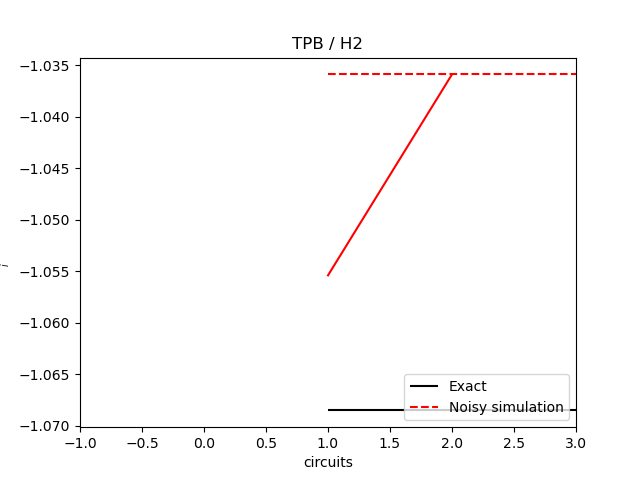

In [68]:
fig, ax = plt.subplots()

data = np.array(energies_TPB_temp)
x = np.arange(1, len(data) + 1)
mask = data > 0

ax.plot(x, np.cumsum(data), 'r')
ax.hlines(energy_exact, 1, len(data) + 1, color='k', label='Exact')
ax.hlines(sum(data), 1, len(data) + 1, color='r', ls='--', label='Noisy simulation')

# ax.plot(x, np.abs(data))

# ax.bar(x[mask], np.abs(data)[mask], width=1, color='b', label=r'$E_i>0$')
# ax.bar(x[~mask], np.abs(data)[~mask], width=1, color='r', label=r'$E_i\leq0$')

ax.set_xlim(-1, len(data) + 1)
ax.set_xlabel('circuits')
# ax.set_ylabel(r'$|E_i|$ [Ha]')
ax.set_ylabel(r'$\sum_{i}^n E_i$ [Ha]')

# ax.set_yscale('log')

ax.legend(loc=4)
ax.set_title(f'{method} / {molecule_name}');

# EM

In [69]:
temp = load_grouping_data(molecule_name, 'EM')

if temp is not None:
    Groups, Measurements, layout = temp
else:
    Groups, Measurements, layout = groupingWithOrder(paulis, connected=True, print_progress=True)

missing = []
for i in range(np.max(np.array(WC_device)) + 1):
    if i not in layout:
        missing.append(i)    
    
print('Number of groups', len(Groups))

Number of groups 2


In [ ]:
method = 'EM'

n_repeats = 5

for _ in range(n_repeats):
    jobs_EM, energy_EM, energies_EM_temp = compute_energy_sparse(Groups, Measurements, method, layout=layout, n_chunks=shots_EM[molecule_name], return_energy_temp=True)
    relative_EM= np.abs((energy_EM - energy_exact) / energy_exact)

    print('EM energy: {}'.format(energy_EM))
    print('Relative error: {:.3f} %'.format(relative_EM * 100))
    
    try:
        time = sum((job.time_per_step()['COMPLETED'] - job.time_per_step()['RUNNING']).total_seconds() for job in jobs_EM)
        print(f'Simulation time {time} s')
    except KeyError:
        print('WTF IBMQ?')

    save_data(energy_EM, method)

Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/2 [00:00<?, ?it/s]

EM energy: -1.097093263120432
Relative error: 2.675 %
Simulation time 1.08 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
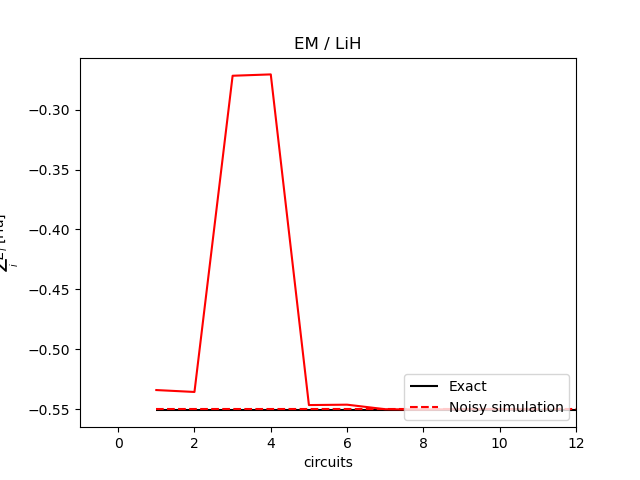

In [55]:
fig, ax = plt.subplots()

data = np.array(energies_EM_temp)
x = np.arange(1, len(data) + 1)
mask = data > 0

ax.plot(x, np.cumsum(data), 'r')
ax.hlines(energy_exact, 1, len(data) + 1, color='k', label='Exact')
ax.hlines(sum(data), 1, len(data) + 1, color='r', ls='--', label='Noisy simulation')

# ax.plot(x, np.abs(data))

# ax.bar(x[mask], np.abs(data)[mask], width=1, color='b', label=r'$E_i>0$')
# ax.bar(x[~mask], np.abs(data)[~mask], width=1, color='r', label=r'$E_i\leq0$')

ax.set_xlim(-1, len(data) + 1)
ax.set_xlabel('circuits')
# ax.set_ylabel(r'$|E_i|$ [Ha]')
ax.set_ylabel(r'$\sum_{i}^n E_i$ [Ha]')

# ax.set_yscale('log')

ax.legend(loc=4)
ax.set_title(f'{method} / {molecule_name}');

# HEEM

In [56]:
temp = load_grouping_data(molecule_name, 'HEEM')

if temp is not None:
    Groups, Measurements, layout = temp
else:
    Groups, Measurements, layout = groupingWithOrder(paulis, G_device, connected=True, print_progress=True)

missing = []
for i in range(np.max(np.array(WC_device)) + 1):
    if i not in layout:
        missing.append(i)    

print('Number of groups', len(Groups))

Number of groups 11


In [57]:
method = 'HEEM'

n_repeats = 5

for _ in range(n_repeats):
    jobs_HEEM, energy_HEEM, energies_HEEM_temp = compute_energy_sparse(Groups, Measurements, method, n_chunks=shots_HEEM[molecule_name], layout=layout, return_energy_temp=True)
    relative_HEEM = np.abs((energy_HEEM - energy_exact) / energy_exact)

    print('HEEM energy: {}'.format(energy_HEEM))
    print('Relative error: {:.3f} %'.format(relative_HEEM * 100))
    
    try:
        time = sum((job.time_per_step()['COMPLETED'] - job.time_per_step()['RUNNING']).total_seconds() for job in jobs_HEEM)
        print(f'Simulation time {time} s')
    except KeyError:
        print('WTF IBMQ?')

    save_data(energy_HEEM, method)

Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/11 [00:00<?, ?it/s]

HEEM energy: -0.5514218541089151
Relative error: 0.072 %
Simulation time 1.527 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/11 [00:00<?, ?it/s]

HEEM energy: -0.5479518732160972
Relative error: 0.558 %
Simulation time 1.547 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/11 [00:00<?, ?it/s]

HEEM energy: -0.5472438131963147
Relative error: 0.686 %
Simulation time 1.651 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/11 [00:00<?, ?it/s]

HEEM energy: -0.550313653288874
Relative error: 0.129 %
Simulation time 2.696 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/11 [00:00<?, ?it/s]

HEEM energy: -0.5542761544068631
Relative error: 0.590 %
Simulation time 3.251 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
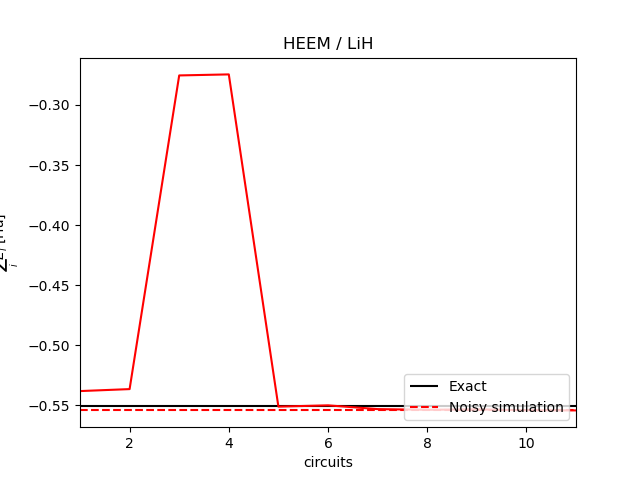

In [58]:
fig, ax = plt.subplots()

data = np.array(energies_HEEM_temp)
x = np.arange(1, len(data) + 1)
mask = data > 0

ax.plot(x, np.cumsum(data), 'r')
ax.hlines(energy_exact, 1, len(data) + 1, color='k', label='Exact')
ax.hlines(sum(data), 1, len(data) + 1, color='r', ls='--', label='Noisy simulation')

# ax.plot(x, np.abs(data))

# ax.bar(x[mask], np.abs(data)[mask], width=1, color='b', label=r'$E_i>0$')
# ax.bar(x[~mask], np.abs(data)[~mask], width=1, color='r', label=r'$E_i\leq0$')

ax.set_xlim(1, len(data))
ax.set_xlabel('circuits')
# ax.set_ylabel(r'$|E_i|$ [Ha]')
ax.set_ylabel(r'$\sum_{i}^n E_i$ [Ha]')

# ax.set_yscale('log')

ax.legend(loc=4)
ax.set_title(f'{method} / {molecule_name}');